In [1]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
import os

In [2]:
# check working directory
print(os.getcwd())


C:\Users\talha\Downloads\mern_app\XGBoostModel


In [3]:
# Load the dataset
df = pd.read_csv('../data/college_student_management_data.csv', delimiter=',')

In [4]:
# Step 1: Check original class distribution before encoding
print("➡️ Original risk_level value counts (before encoding):")
print(df['risk_level'].value_counts())
print()

➡️ Original risk_level value counts (before encoding):
risk_level
High      805
Medium    456
Low       284
Name: count, dtype: int64



In [5]:
# Step 2: Prepare features and labels
X = df.drop(columns=['risk_level', '_id'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['risk_level'])


In [6]:
# Check label mapping
print("➡️ Label encoding mapping:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print()


➡️ Label encoding mapping:
{'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}



In [7]:
# Step 3: Check class distribution after encoding
print("➡️ Class distribution after encoding (full dataset):")
print(pd.Series(y).value_counts())
print()


➡️ Class distribution after encoding (full dataset):
0    805
2    456
1    284
Name: count, dtype: int64



In [8]:
# Step 4: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=8
)

In [9]:
# Step 5: Check class distribution after split
print("➡️ y_train class distribution:")
print(pd.Series(y_train).value_counts())
print()


print("➡️ y_test class distribution:")
print(pd.Series(y_test).value_counts())
print()

➡️ y_train class distribution:
0    644
2    365
1    227
Name: count, dtype: int64

➡️ y_test class distribution:
0    161
2     91
1     57
Name: count, dtype: int64



In [10]:
# Step 6: Compute sample weights
class_weights = dict(enumerate(
    len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))
))

sample_weight = np.array([class_weights[label] for label in y_train])
print("➡️ Computed class weights:")
print(class_weights)
print()

print("➡️ Sample of sample_weight values:")
print(sample_weight[:10])
print()

➡️ Computed class weights:
{0: np.float64(0.639751552795031), 1: np.float64(1.8149779735682818), 2: np.float64(1.1287671232876713)}

➡️ Sample of sample_weight values:
[0.63975155 0.63975155 0.63975155 0.63975155 1.81497797 1.12876712
 0.63975155 1.12876712 1.12876712 1.81497797]



In [11]:
# Encode string labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y = le.fit_transform(df['risk_level'])
print(le.classes_)

['High' 'Low' 'Medium']


In [12]:
pipe = Pipeline([
    ('encoder', TargetEncoder(cols=['gender', 'major', 'enrollment_status'])),
    ('clf', XGBClassifier(
        num_class=len(le.classes_),
        eval_metric='mlogloss',
        max_depth=4,
        learning_rate=0.3,
        n_estimators=100,
        random_state=42
    ))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['gender', 'major', 'enrollment_status'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None, num_class=3, ...))])

In [13]:
# Predict class labels
y_pred = pipe.predict(X_test)

# Predict class probabilities
y_prob = pipe.predict_proba(X_test)


print("\n Accuracy:", accuracy_score(y_test, y_pred))
print(le.classes_)
print("\n Classification Report:\n",
      classification_report(y_test, y_pred, target_names=le.classes_))

print("\n Predicted class labels:", y_pred[:5])
print(" Actual class labels   :", y_test[:5])

print("\n Predicted probabilities for first 5 samples:\n", y_prob[:5])
print("Train set size:", len(y_train))
print("Test set size :", len(y_test))


 Accuracy: 1.0
['High' 'Low' 'Medium']

 Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00       161
         Low       1.00      1.00      1.00        57
      Medium       1.00      1.00      1.00        91

    accuracy                           1.00       309
   macro avg       1.00      1.00      1.00       309
weighted avg       1.00      1.00      1.00       309


 Predicted class labels: [1 0 2 0 2]
 Actual class labels   : [1 0 2 0 2]

 Predicted probabilities for first 5 samples:
 [[7.94448482e-04 9.98036683e-01 1.16888061e-03]
 [9.98842716e-01 3.34219425e-04 8.23033624e-04]
 [5.88330673e-04 8.53982521e-04 9.98557746e-01]
 [9.98901606e-01 1.04816936e-04 9.93580557e-04]
 [5.94129961e-04 8.53977515e-04 9.98551905e-01]]
Train set size: 1236
Test set size : 309


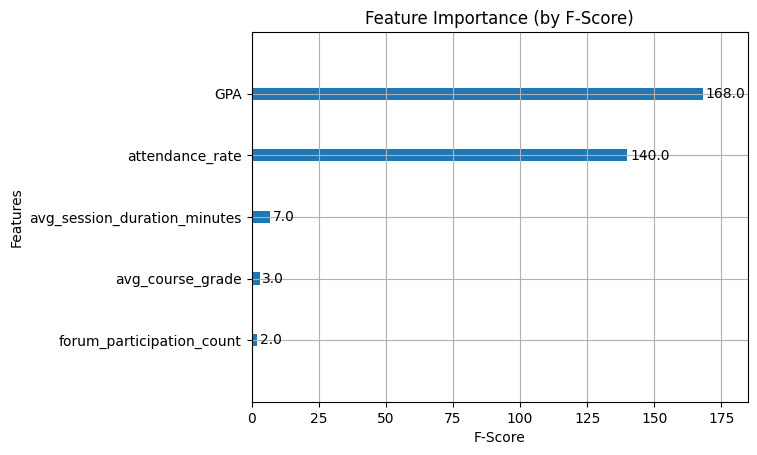

In [14]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

fitted_model = pipe.named_steps['clf']
plot_importance(fitted_model, importance_type='weight', xlabel='F-Score')
plt.title("Feature Importance (by F-Score)")
plt.show()

In [15]:
features = [
    'age',
    'gender',
    'major',
    'GPA',
    'course_load',
    'avg_course_grade',
    'attendance_rate',
    'enrollment_status',
    'lms_logins_past_month',
    'avg_session_duration_minutes',
    'assignment_submission_rate',
    'forum_participation_count',
    'video_completion_rate'
]

sample = [[
    20,                 # age (int)
    'Male',             # gender (str)
    'Computer Science', # major (str)
    3.8,                # GPA (float)
    4,                  # course_load (int)
    1,                 # avg_course_grade (int or float)
    0.9,                # attendance_rate (float)
    'Full-time',        # enrollment_status (str)
    5,                 # lms_logins_past_month (int)
    30,                 # avg_session_duration_minutes (int)
    0.10,               # assignment_submission_rate (float)
    1,                  # forum_participation_count (int)
    0.8                 # video_completion_rate (float)
]]

sample_df = pd.DataFrame(sample, columns=features)

# Predict numeric label
predicted_num_label = pipe.predict(sample_df)

# Convert back to original label
predicted_label = le.inverse_transform(predicted_num_label)

print("Predicted label:", predicted_label[0])


Predicted label: Low
